In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

planes = pd.read_csv('../Data/Airplane_Crashes_and_Fatalities_since_1908.csv',encoding = "utf-8")
print('This is the data')
planes.head()

This is the data


,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    if not pd.isnull(text):
        # Remove non-alphabetic characters and lowercase the text
        text = re.sub('[^A-Za-z]', ' ', text).lower()
        # Tokenize the text
        text = text.split()
        # Remove stopwords and lemmatize the words
        text = [lemmatizer.lemmatize(word) for word in text if word not in set(stopwords.words('english'))]
        # Join back together
        text = ' '.join(text)
        return text
    else:
        return ""

# Apply the cleaning function to the summary column
planes['Cleaned_Summary'] = planes['Summary'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbethmatibe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbethmatibe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Calculate percentage of fatalities
planes['Severity_Percentage'] = (planes['Fatalities'] / planes['Aboard']) * 100

# Handle any infinities or missing values that might arise from division by zero or NaNs
planes['Severity_Percentage'].replace([np.inf, -np.inf], np.nan, inplace=True)
planes.dropna(subset=['Severity_Percentage'], inplace=True)


In [4]:
# Dropping rows where 'Cleaned_Summary' or 'Severity_Percentage' is NaN
planes.dropna(subset=['Cleaned_Summary', 'Severity_Percentage'], inplace=True)

# Reset index after dropping rows
planes.reset_index(drop=True, inplace=True)


In [5]:
planes.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Cleaned_Summary,Severity_Percentage
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",demonstration flight u army flyer flown orvill...,50.0
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,first u dirigible akron exploded offshore alti...,100.0
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,first fatal airplane accident canada occurred ...,100.0
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,airship flew thunderstorm encountered severe d...,70.0
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,hydrogen gas vented sucked forward engine igni...,100.0


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, # Limit number of features to 1000 for simplicity
                                   ngram_range=(1,2), # Consider both unigrams and bigrams
                                   min_df=5, # Words must appear in at least 5 documents
                                   max_df=0.9) # Words must not appear in more than 90% of the documents

# Fit and transform the cleaned summaries
tfidf_features = tfidf_vectorizer.fit_transform(planes['Cleaned_Summary'])

# This returns a sparse matrix. To convert it to a DataFrame:
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [7]:
from textblob import TextBlob

# Function to get the polarity score
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the cleaned summaries
planes['Polarity'] = planes['Cleaned_Summary'].apply(get_polarity)

In [8]:
# Add the polarity score to the tfidf_df
tfidf_df['Polarity'] = planes['Polarity'].values

# Define the features and target variable
X = tfidf_df  # Features include the TF-IDF scores and the polarity score
y = planes['Severity_Percentage']  # Target variable

# Now, X and y are prepared for a regression model 

In [9]:
X['Polarity']

0      -0.103846
1       0.250000
2       0.016667
3       0.000000
4       0.000000
          ...   
5239   -0.100000
5240    0.000000
5241    0.009524
5242   -0.200000
5243   -0.156250
Name: Polarity, Length: 5244, dtype: float64

In [10]:
y

0        50.0
1       100.0
2       100.0
3        70.0
4       100.0
        ...  
5239     87.5
5240    100.0
5241    100.0
5242    100.0
5243    100.0
Name: Severity_Percentage, Length: 5244, dtype: float64

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Polarity', ylabel='Severity_Percentage'>

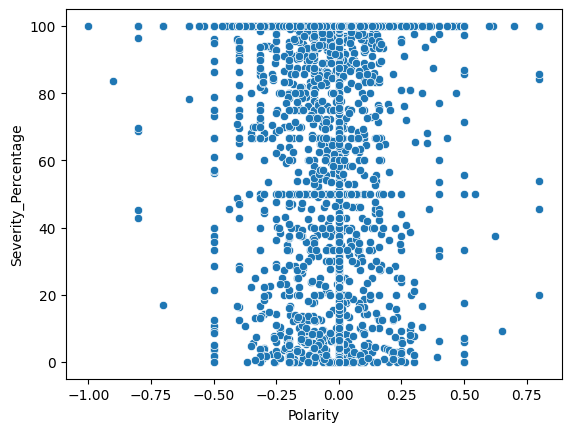

In [11]:
sns.scatterplot(X['Polarity'], y)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


Xx = X[['Polarity']]  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xx, y, test_size=0.6, random_state=42)

# Initialize the SVM Regressor
svm_reg = SVR(kernel='rbf', C=1.0, gamma='scale', 
              epsilon=0.2)

# Fit the regressor to the training data
svm_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_reg.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 16.98659336548273
Root Mean Squared Error (RMSE): 34.456580137044774


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

Xx = X[['Polarity']] #.reshape[-1, 1] #using just polarity score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xx, y, test_size=0.6)

# Initialize and train the Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 23.279660200515256
Root Mean Squared Error (RMSE): 31.986537109164967


In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor object
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                           n_estimators=100, 
                           learning_rate=0.1, 
                           max_depth=3, 
                           seed=42)

# Fit the regressor to the training set
xgb_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_reg.predict(X_test)

# Calculate the MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 19.785154387916958
Root Mean Squared Error (RMSE): 27.242789628962974


In [15]:
# XGBoost cross-validation
params = {
    'objective': 'reg:squarederror',
    'max_depth': 3,
    'learning_rate': 0.1,
    'silent': 1,
    'n_estimators': 100
}

dtrain = xgb.DMatrix(X_train, label=y_train)
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3, 
                    num_boost_round=50, early_stopping_rounds=10, 
                    metrics='rmse', as_pandas=True, seed=42)

print(f"CV RMSE: {cv_results['test-rmse-mean'].min()}")

[21:49:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators", "silent" } are not used.

[21:49:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators", "silent" } are not used.

[21:49:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators", "silent" } are not used.

CV RMSE: 26.114864885852356
